In [1]:
# Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

# Import Qiskit classes 
import qiskit
from qiskit import assemble, transpile
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

# The RB Protocol
* STEP 1 : Generate RB Sequences
Random clifford elements chosen uniformly from the clifford group on n-qubits, including a reversal element.

* STEP 2 : Execute RB sequences with some noise
Execute the RB sequences using the simulator or the IBMQ provider.
Each C_i,j is allowed to have some error and it can be modeled by an operation.

* STEP 3 : Get statistics about the survival probabilities
For each K_m sequences the survival probabilities is measured. In practice the probability to go bck to the initial state or ground state.

* STEP 4 : Find average sequenced fidelity
Average over the K_m random realizations of the sequence to find the averaged sequence fidelity.

* STEP 5 : Fit the results
For different values of m the program is rerun and fit the results for the averaged sequence to the model.
the average error rate OR Error per Clifford (EPC) is found out.

### STEP 1

In [2]:
# num of qubits
nQ = 2
rb_opts = {}

#num of clifford in the sequence
rb_opts['length_vector'] = [1,10,20,50,75,100,125,150,175,200]
# num of seeds(random sequences)
rb_opts['nseeds'] = 5
#default pattern
rb_opts['rb_pattern'] = [[0,1]]

rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)



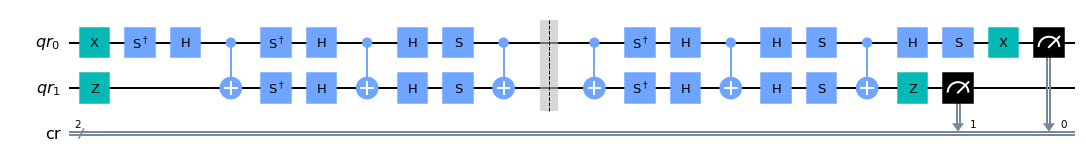

In [4]:
# Draw the QuantumCircuit at [0][0]
rb_circs[0][0].draw('mpl')

In [5]:
#verify that the unitary representing each RB circuit is identity using Aer 
from qiskit import QuantumCircuit
# new circuit without measurement
qregs = rb_circs[0][-1].qregs
cregs = rb_circs[0][-1].cregs
qc = QuantumCircuit(*qregs,*cregs)
for i in rb_circs[0][-1][0:-nQ]:
    qc.data.append(i)
    
# The Unitary is an identity (with a global phase)
sim = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
qc.save_unitary()
unitary = sim.run(qc).result().get_unitary()

#Printing the Unitary to tell that it is identity matrix
from qiskit.visualization import array_to_latex
array_to_latex(unitary, prefix="\\text{Unitary} = ")

<IPython.core.display.Latex object>

### STEP 2

In [6]:
# Run on a noisy simulator
noise_model = NoiseModel()

# Depolarizing error on the gates u2, u3 and cx (assuming the u1 is virtual-Z gate and no error)
p1Q = 0.002
p2Q = 0.01

noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2 * p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

backend = qiskit.Aer.get_backend('aer_simulator')

### STEP 3,4,5

In [9]:
# Create the RB fitter
backend = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['u1','u2','u3','cx'] 
shots = 200
transpiled_circs_list = []
rb_fit = rb.RBFitter(None, xdata, rb_opts['rb_pattern'])
#print(type(rb_fit))

#For every circuit in 'rb_circs' create a list with the seed and its respective circuit
for rb_seed, rb_circ_seed in enumerate(rb_circs): 
    #print(type(rb_circ_seed))
    print(f'Compiling seed {rb_seed}')
    
    #transpiling the given gates into the above defined basis gates
    new_rb_circ_seed = qiskit.compiler.transpile(rb_circ_seed, basis_gates=basis_gates)
    transpiled_circs_list.append(new_rb_circ_seed)
    print(f'Simulating seed {rb_seed}')
    qobj = assemble(new_rb_circ_seed, shots=shots) #Quantum Object Assemble
    job = backend.run(qobj,
                      noise_model=noise_model,
                      max_parallel_experiments=0) #Running the Quantum Circuit
    
    # Add data to the fitter
    #print((job.result()))
    rb_fit.add_data(job.result())
    
    #Printing the Alpha and EPC values
    print('After seed %d, alpha: %f, EPC: %f'%(rb_seed,rb_fit.fit[0]['params'][1], rb_fit.fit[0]['epc']))

Compiling seed 0
Simulating seed 0
After seed 0, alpha: 0.982826, EPC: 0.012880
Compiling seed 1
Simulating seed 1
After seed 1, alpha: 0.984283, EPC: 0.011788
Compiling seed 2
Simulating seed 2
After seed 2, alpha: 0.981802, EPC: 0.013648
Compiling seed 3
Simulating seed 3
After seed 3, alpha: 0.981840, EPC: 0.013620
Compiling seed 4
Simulating seed 4
After seed 4, alpha: 0.981726, EPC: 0.013706


## Plotting the results

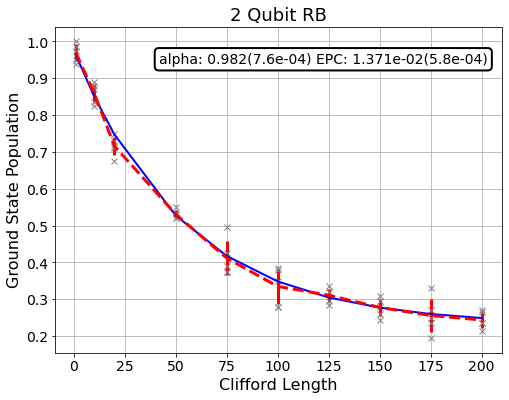

In [10]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rb_fit.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title('%d Qubit RB'%(nQ), fontsize=18)

plt.show()

## Predicted gate fidelity

If we know the errors on the underlying gates we can predict tyhe EPC without running the RB experiment.

This verifies that the RB experiment followed by fitting yields correct EPC value. 

In [11]:
# count the number of single and 2Q gates in the 2Q Cliffords
qubits = rb_opts['rb_pattern'][0]

gate_per_cliff = rb.rb_utils.gates_per_clifford(
    transpiled_circuits_list=transpiled_circs_list,
    clifford_lengths=xdata[0],
    basis=basis_gates,
    qubits=qubits)

for basis_gate in basis_gates:
    print("Number of %s gates per Clifford: %f"%(
        basis_gate,
        np.mean([gate_per_cliff[qubit][basis_gate] for qubit in qubits])))

Number of u1 gates per Clifford: 0.113319
Number of u2 gates per Clifford: 1.664738
Number of u3 gates per Clifford: 0.172926
Number of cx gates per Clifford: 1.501528


In [12]:
# convert from depolarizing error to epg (1Q)
epg_q0 = {'u1': 0, 'u2': p1Q/2, 'u3': 2 * p1Q/2}
epg_q1 = {'u1': 0, 'u2': p1Q/2, 'u3': 2 * p1Q/2}

# convert from depolarizing error to epg (2Q)
epg_q01 = 3/4 * p2Q

# calculate the predicted epc from underlying gate errors 
pred_epc = rb.rb_utils.calculate_2q_epc(
    gate_per_cliff=gate_per_cliff,
    epg_2q=epg_q01,
    qubit_pair=qubits,
    list_epgs_1q=[epg_q0, epg_q1])

print("Predicted 2Q Error per Clifford: %e (aer simulator result: %e)" % (pred_epc, rb_fit.fit[0]['epc']))

Predicted 2Q Error per Clifford: 1.597518e-02 (aer simulator result: 1.370561e-02)


In [13]:
# use 2Q EPC from aer simulator result and 1Q EPGs from depolarizing error model
pred_epg = rb.rb_utils.calculate_2q_epg(
    gate_per_cliff=gate_per_cliff,
    epc_2q=rb_fit.fit[0]['epc'],
    qubit_pair=qubits,
    list_epgs_1q=[epg_q0, epg_q1])

print("Predicted 2Q Error per gate: %e (gate error model: %e)" % (pred_epg, epg_q01))

Predicted 2Q Error per gate: 5.959889e-03 (gate error model: 7.500000e-03)
